<a href="https://colab.research.google.com/github/ankygupta9999/DL-image-captioning/blob/main/DL_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Loading**

In [16]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
import pandas as pd
import pickle
import os, re
import zipfile
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [18]:
DIR_PATH = "/content/gdrive/MyDrive/Datasets"
CAPTIONS_PATH = os.path.join(DIR_PATH, "set_1.pkl")

objects = pd.read_pickle(CAPTIONS_PATH)
print('First entry in pickle file:')
print(objects[0], '\n')
print('Total entries in pickle file = ', len(objects), '\n')

First entry in pickle file:
2089122314_40d5739aef.jpg#3	A fluffy , tri-colored dog be run down a road with a paper in its mouth . 

Total entries in pickle file =  25000 



In [ ]:
IMAGES_PATH = os.path.join(DIR_PATH, "Image_captioning_Dataset.zip")

with zipfile.ZipFile(IMAGES_PATH, 'r') as zip_ref:
    zip_ref.extractall(DIR_PATH)

In [19]:
IMAGES_DIR = os.path.join(DIR_PATH, "Flicker8k_Dataset")

**Data Extraction (DataFrame)**

In [20]:
raw_df = pd.DataFrame()

for i, row in enumerate(objects):
  img_dict = {}
  img_dict['img_nm'] = str(row).split('#')[0]
  img_dict['caption_id'] = row.split(img_dict['img_nm'])[1].split('\t')[0]
  img_dict['img_caption'] = row.split('\t')[1]
  raw_df =raw_df.append(img_dict, ignore_index=True)

raw_df.head()

,caption_id,img_caption,img_nm
0,#3,"A fluffy , tri-colored dog be run down a road ...",2089122314_40d5739aef.jpg
1,#0,A crowd of person be stand together on a sidew...,1295671216_cde1b9c9d1.jpg
2,#4,"The man and boy sit on the ground , next to a ...",3183195185_cd0ff994a1.jpg
3,#1,A brown dog be play with a white fluffy stuff ...,2949353587_64c54e9589.jpg
4,#2,A man hike with a large backpack and two pole ...,361092202_3d70144ebd.jpg


In [21]:
raw_df.info(verbose=True)
print('\n')
print('Unique image names = ', len(raw_df.img_nm.unique()), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   caption_id   25000 non-null  object
 1   img_caption  25000 non-null  object
 2   img_nm       25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


Unique image names =  8033 



**Data Extraction (Dictionary)**

In [22]:
def map_captions_images(captions_path, images_dir):
  captions_data = pd.read_pickle(captions_path)
  captions_mapping = {} # dictionary mapping image names to captions
  captions_text = [] # list of all captions
  img_cnt = 0

  for i, row in enumerate(captions_data):
    img_name = str(row).split('#')[0] # get image name
    img_name = img_name.strip()
    #img_name = os.path.join(images_dir, img_name.strip()) # append image path
    img_caption = row.split('\t')[1] # get image caption

    if img_name.endswith("jpg"):
      img_cnt += 1
      img_caption = "<start> " + img_caption.strip() + " <end>" # add start & end token
      captions_text.append(img_caption)
      if img_name in captions_mapping:
        captions_mapping[img_name].append(img_caption)
      else:
        captions_mapping[img_name] = [img_caption]
  
  print('Total jpg images = ', img_cnt, '\n')

  return captions_mapping, captions_text

captions_mapping, captions_text = map_captions_images(CAPTIONS_PATH, IMAGES_DIR)

Total jpg images =  24996 



**Sample Printing (DataFrame)**

In [23]:
def print_sample_imgs(img_dir, pics, nrows, ncols, nimages, df):
  nrows = nrows
  ncols = ncols

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("============== Printing Sample images ================")
  print("======================================================")
  j = 1
  for i, img_nm in enumerate(pics):
    if i < nimages:
      # print ("printing {} , image :{}".format(i, img_nm))
      caption = list(df[df['img_nm'] == img_nm]['img_caption'])[0]
      just_img_nm = img_nm.split(sep='.')[0]
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, j)
      sp.axis('Off') # Don't show axes (or gridlines)
      sp.set_title("Img # "+ str(i+1) + " - Caption :" +caption, loc='left')
      raw_img_nm = img_dir + '/' + img_nm
      img = mpimg.imread(raw_img_nm)
      plt.imshow(img)

      j = j + 1
    else:
      break
  plt.show()

============== Printing Sample images ================


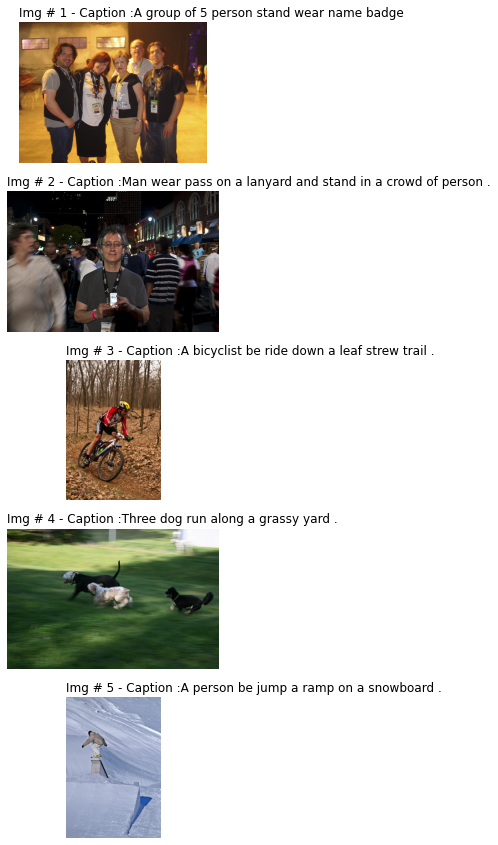

In [24]:
print_sample_imgs(IMAGES_DIR, os.listdir(IMAGES_DIR), nrows=5, ncols=1, nimages=5, df=raw_df)

**Sample Printing (Dictionary)**

In [25]:
def plot_sample_imgs(img_dir, pics, nrows, ncols, nimages, df):
  nrows = nrows
  ncols = ncols

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("============== Printing Sample images ================")
  print("======================================================")
  j = 1
  for i, img_name in enumerate(pics):
    if i < nimages:
      # print ("printing {} , image :{}".format(i, img_nm))
      #caption = list(df[df['img_nm'] == img_nm]['img_caption'])[0]
      caption = captions_mapping[img_name]
      just_img_name = img_name.split(sep='.')[0]
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, j)
      sp.axis('Off') # Don't show axes (or gridlines)
      sp.set_title("Img # "+ str(i+1) + " - Caption :" + str(caption), loc='left')
      raw_img_name = img_dir + '/' + img_name
      img = mpimg.imread(raw_img_name)
      plt.imshow(img)

      j = j + 1
    else:
      break
  plt.show()

============== Printing Sample images ================


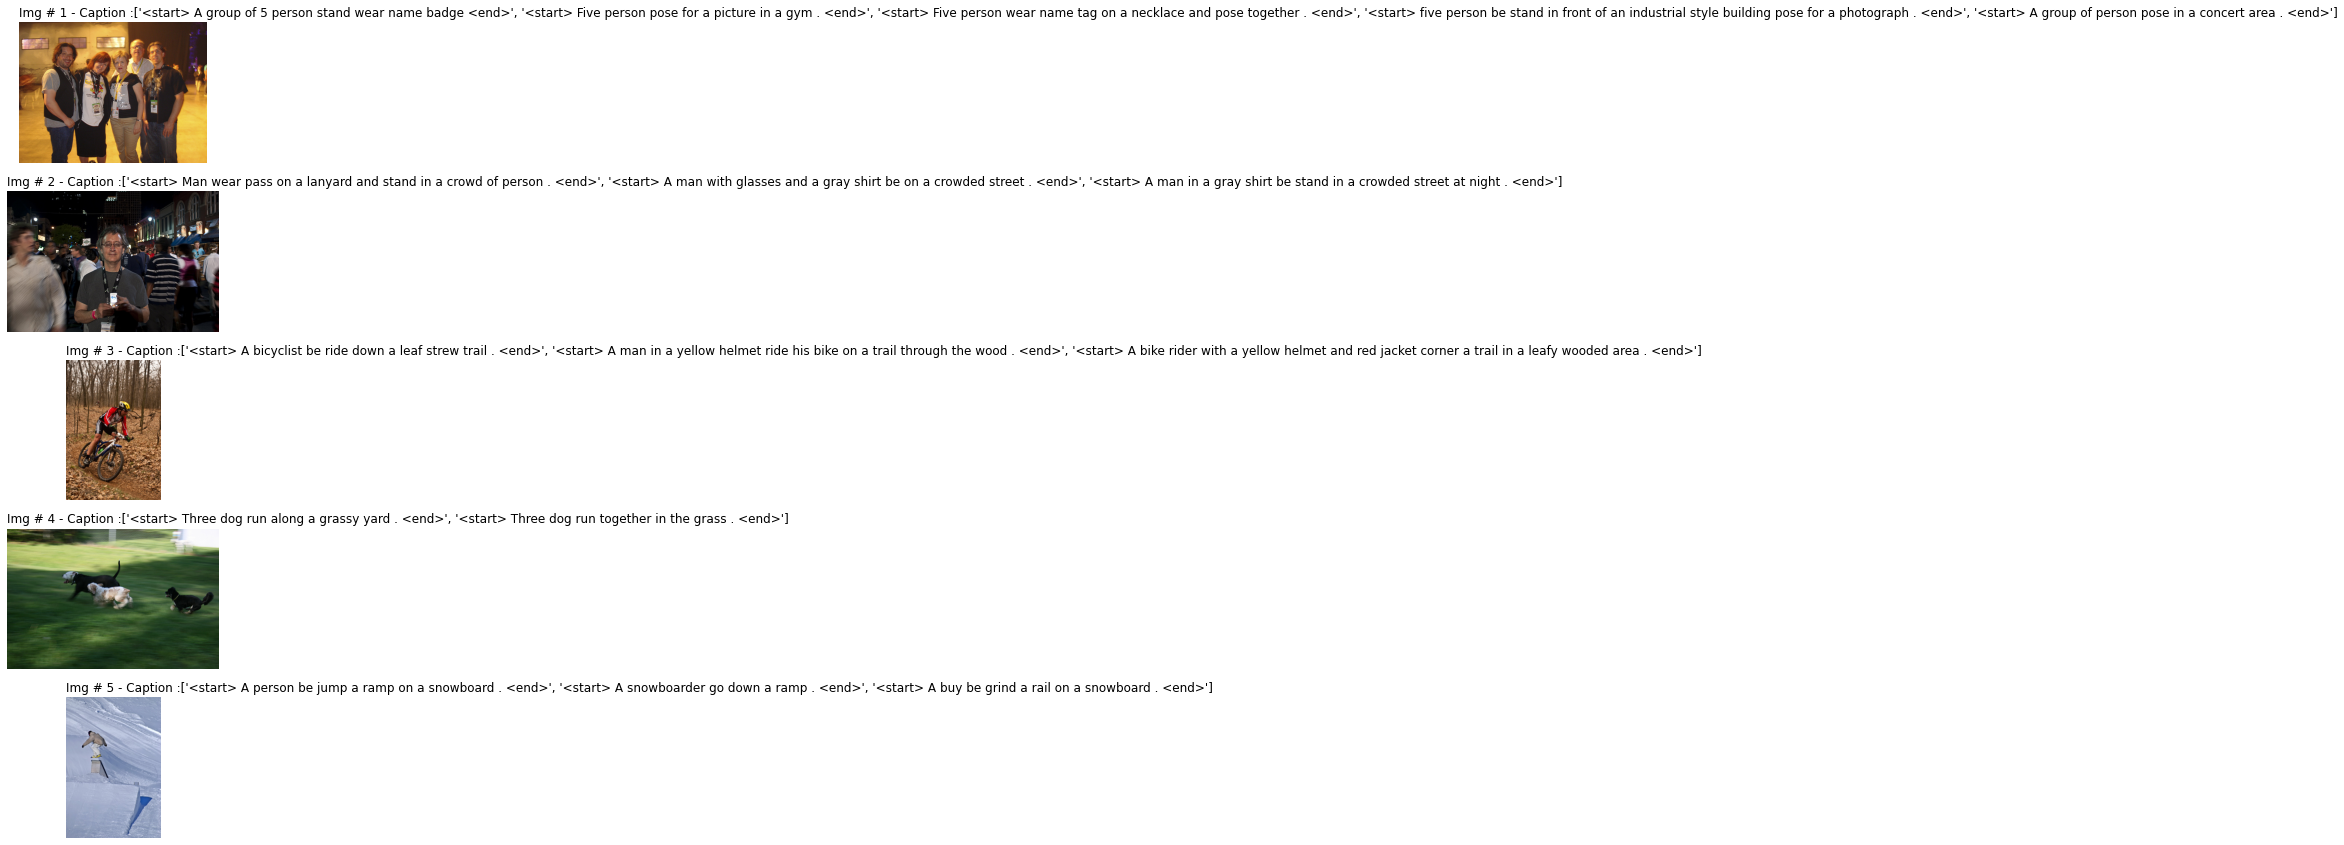

In [26]:
plot_sample_imgs(IMAGES_DIR, os.listdir(IMAGES_DIR), nrows=5, ncols=1, nimages=5, df=raw_df)

**Data Preparation (Dictionary)**

a) Split between training and validation

b) Vectorise

c) Build pipeline for model training


*   Read image from disk
*   Tokenise all captions corresponding to image



In [27]:
def train_val_split(captions_mapping, train_size=0.8, shuffle=True):
    image_names = list(captions_mapping.keys()) # list of all image names

    if shuffle:
        np.random.shuffle(image_names) # shuffle

    train_size = int(len(captions_mapping) * train_size) # split into training & validation

    training_data = {
        img_name: captions_mapping[img_name] for img_name in image_names[:train_size]
    }
    validation_data = {
        img_name: captions_mapping[img_name] for img_name in image_names[train_size:]
    }

    return training_data, validation_data

training_data, validation_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  6425
Number of validation samples:  1607


In [28]:
IMAGE_SIZE = (299, 299) # Desired image dimensions
VOCAB_SIZE = 10000 # Vocabulary size
SEQ_LENGTH = 20 # Fixed length allowed for any sequence
EMBED_DIM = 512 # Dimension for the image embeddings and token embeddings
NUM_HEADS = 2 # Number of self-attention heads
FF_DIM = 512 # Per-layer units in the feed-forward network
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 0.00001

In [29]:
def get_cleaned_text(text):
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"
    text_lower = tf.strings.lower(text)
    return tf.strings.regex_replace(text_lower, "[%s]" % re.escape(strip_chars), "")

vectorization = TextVectorization(
                  max_tokens=VOCAB_SIZE,
                  output_mode="int",
                  output_sequence_length=SEQ_LENGTH,
                  standardize=get_cleaned_text,
                )
vectorization.adapt(captions_text)

In [30]:
vectorization.get_vocabulary()[:15] # Top vocabulary words

['',
 '[UNK]',
 'a',
 '<start>',
 '<end>',
 'in',
 'be',
 'the',
 'on',
 'dog',
 'and',
 'man',
 'with',
 'of',
 'two']

In [31]:
def read_image(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions):
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
        read_image, num_parallel_calls=AUTOTUNE
    )
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset

# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(training_data.keys()), list(training_data.values()))
valid_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

ValueError: ignored